In [13]:
# Load the python libraries for dataprocessing and model and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

import mglearn

In [14]:
# Load the entire dataset into a pandas dataframe

df = pd.read_parquet('/nobackup/amimalik/bits/dataset/dimensions/4Q/working_dataset.parquet')
model_df = pd.read_csv('/nobackup/amimalik/bits/dataset/dimensions/4Q/sorted_failures.csv')

In [15]:
def get_model_data(df, model):
    model_df = df[df['model'] == model]
    model_df = model_df.drop(columns=['model'])
    return model_df.drop(columns=['serial_number'])

In [16]:
final_df = get_model_data(df, 'ST12000NM0008')
final_df.head()

,failure,Reallocated_Sectors_Count,Power-On_Hours,I/O_Error_Detection_and_Correction,Reported_Uncorrectable_Errors,Load_Unload_Cycle,Current_Pending_Sector_Count,Offline_Uncorrectable,Head_Flying_Hours,Total_LBAs_Written,Total_LBAs_Read
66599,0.0,0.0,0.388091,NaN,0.0,0.005801,0.0,0.0,0.386180,0.334548,0.104218
66866,0.0,0.0,0.388064,NaN,0.0,0.005690,0.0,0.0,0.386114,0.359183,0.091892
67071,0.0,0.0,0.388144,NaN,0.0,0.006111,0.0,0.0,0.385941,0.337273,0.099654
67109,0.0,0.0,0.388197,NaN,0.0,0.006115,0.0,0.0,0.386021,0.342008,0.102344
67169,0.0,0.0,0.388104,NaN,0.0,0.005744,0.0,0.0,0.386087,0.339530,0.126195


In [17]:
# Fill NaN values in df with mean of each column
# df.fillna(df.mean(), inplace=True)

# Fill NaN values in final_df with mean of each column
final_df.fillna(final_df.mean(), inplace=True)
final_df.dropna(axis=1, inplace=True)

final_df.describe()

,failure,Reallocated_Sectors_Count,Power-On_Hours,Reported_Uncorrectable_Errors,Load_Unload_Cycle,Current_Pending_Sector_Count,Offline_Uncorrectable,Head_Flying_Hours,Total_LBAs_Written,Total_LBAs_Read
count,53036.000000,53036.000000,53036.000000,53036.000000,53036.000000,53036.000000,53036.000000,53036.000000,53036.000000,53036.000000
mean,0.003281,0.013202,0.404955,0.006321,0.013812,0.000014,0.000014,0.398378,0.359483,0.079098
std,0.057185,0.049771,0.048593,0.078030,0.013295,0.000476,0.000476,0.046442,0.044611,0.023124
min,0.000000,0.000000,0.000053,0.000000,0.003958,0.000000,0.000000,0.241079,0.220027,0.034668
25%,0.000000,0.000000,0.376713,0.000000,0.006243,0.000000,0.000000,0.368398,0.345984,0.062145
50%,0.000000,0.000000,0.409069,0.000000,0.007690,0.000000,0.000000,0.401797,0.371004,0.074125
75%,0.000000,0.000366,0.439354,0.000031,0.011438,0.000000,0.000000,0.431157,0.390393,0.095408
max,1.000000,0.697839,0.516551,1.000000,0.045735,0.086470,0.086470,0.514624,0.457648,0.139238


In [18]:
final_df.head()

,failure,Reallocated_Sectors_Count,Power-On_Hours,Reported_Uncorrectable_Errors,Load_Unload_Cycle,Current_Pending_Sector_Count,Offline_Uncorrectable,Head_Flying_Hours,Total_LBAs_Written,Total_LBAs_Read
66599,0.0,0.0,0.388091,0.0,0.005801,0.0,0.0,0.386180,0.334548,0.104218
66866,0.0,0.0,0.388064,0.0,0.005690,0.0,0.0,0.386114,0.359183,0.091892
67071,0.0,0.0,0.388144,0.0,0.006111,0.0,0.0,0.385941,0.337273,0.099654
67109,0.0,0.0,0.388197,0.0,0.006115,0.0,0.0,0.386021,0.342008,0.102344
67169,0.0,0.0,0.388104,0.0,0.005744,0.0,0.0,0.386087,0.339530,0.126195


we will be using  Gradient Boosting method to train in each dataset. 
will be using GridSearch to find the optimum parameters for each dataset.

In [21]:
models = []
accs = [] #accuracies
recs = [] #recalls
precs = [] #precisions
f1s = [] #f1 scores
rocs = [] #roc auc scores

X = final_df.drop('failure', axis=1)
y = final_df.failure
    
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    gbrt = GradientBoostingClassifier(max_features='sqrt', random_state=0)
    learning_rates = [0.1, 0.05, 0.01]
    n_estimators = [16, 32, 64]
    max_depths = [5, 10, 15]
    
    params = {'learning_rate': learning_rates, 'n_estimators': n_estimators, 'max_depth': max_depths}
    clf = GridSearchCV(gbrt, params)
    clf.fit(X_train, y_train)
    models.append(clf)
    
    final_pred = clf.predict(X_test)
    accs.append(accuracy_score(y_test, final_pred))
    recs.append(recall_score(y_test, final_pred))
    precs.append(precision_score(y_test, final_pred))
    f1s.append(f1_score(y_test, final_pred))
    rocs.append(roc_auc_score(y_test, final_pred))
    print(clf.best_params_)

/ws/amimalik-bgl/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 16}


/ws/amimalik-bgl/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 16}


/ws/amimalik-bgl/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 16}


/ws/amimalik-bgl/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 16}
{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 16}


/ws/amimalik-bgl/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Evaluation

Accuracy, Recall, Precision, F1-Score, AUC-ROC values for the k dataset 

Text(0.5, 1.0, 'Accuracy values of each model')

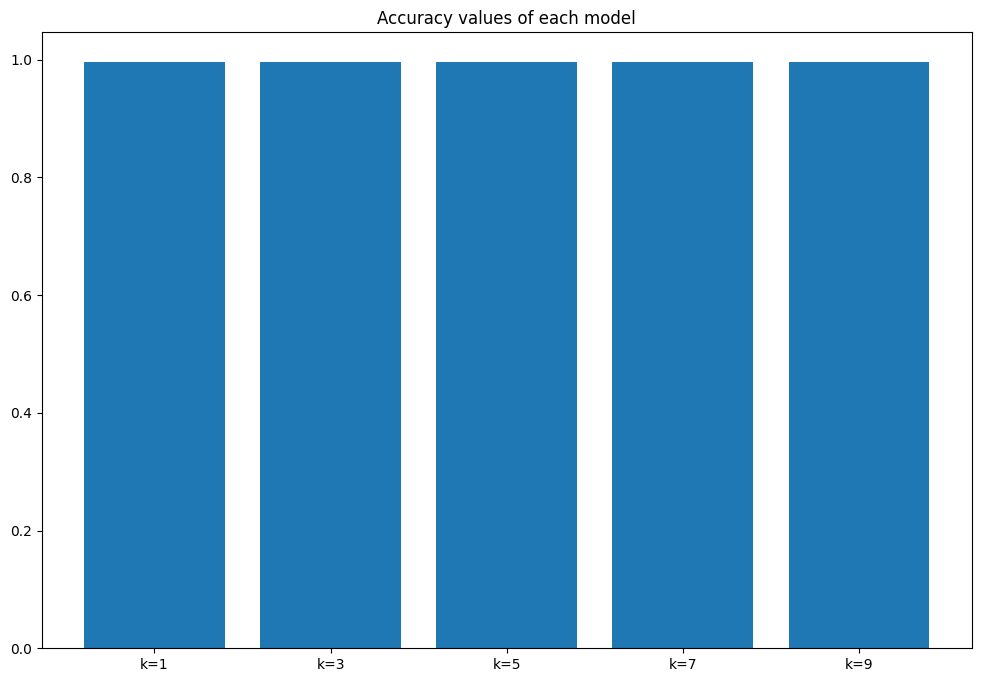

In [22]:
x = ['k=1', 'k=3', 'k=5', 'k=7', 'k=9']

plt.figure(figsize=(12,8))
plt.bar(x, accs)
plt.title('Accuracy values of each model')

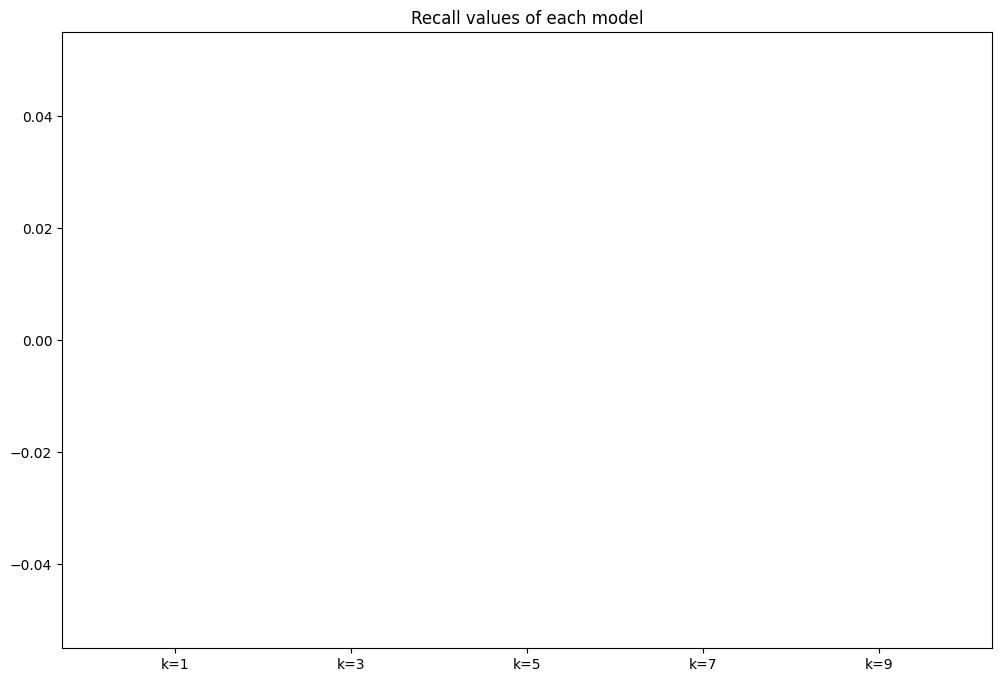

In [23]:
plt.figure(figsize=(12,8))
plt.bar(x, recs)
plt.title('Recall values of each model')
plt.show()

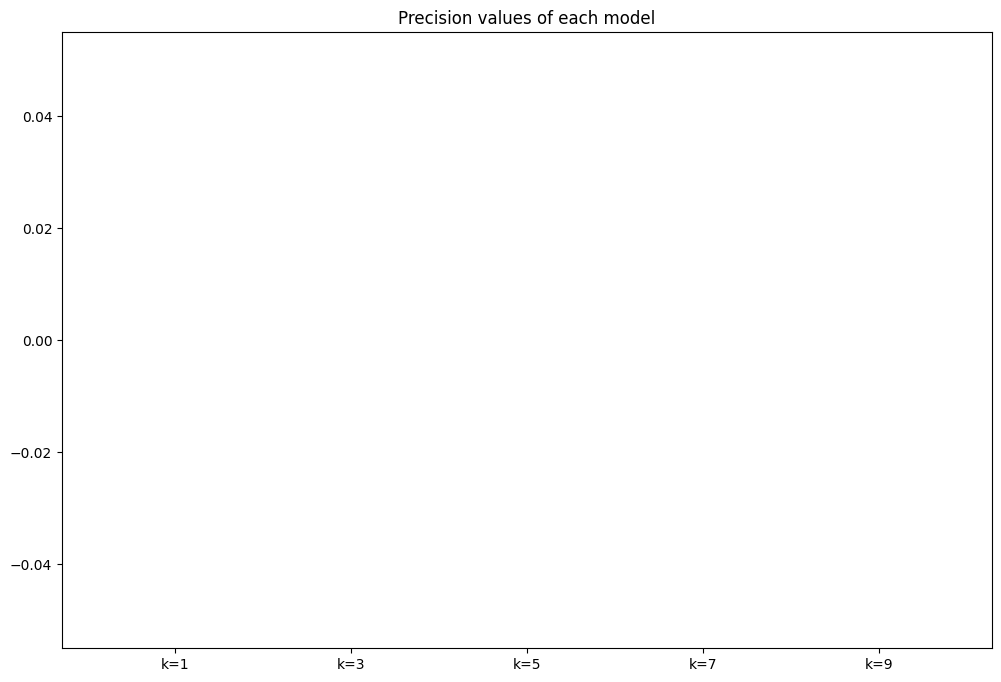

In [24]:
plt.figure(figsize=(12,8))
plt.bar(x, precs)
plt.title('Precision values of each model')
plt.show()

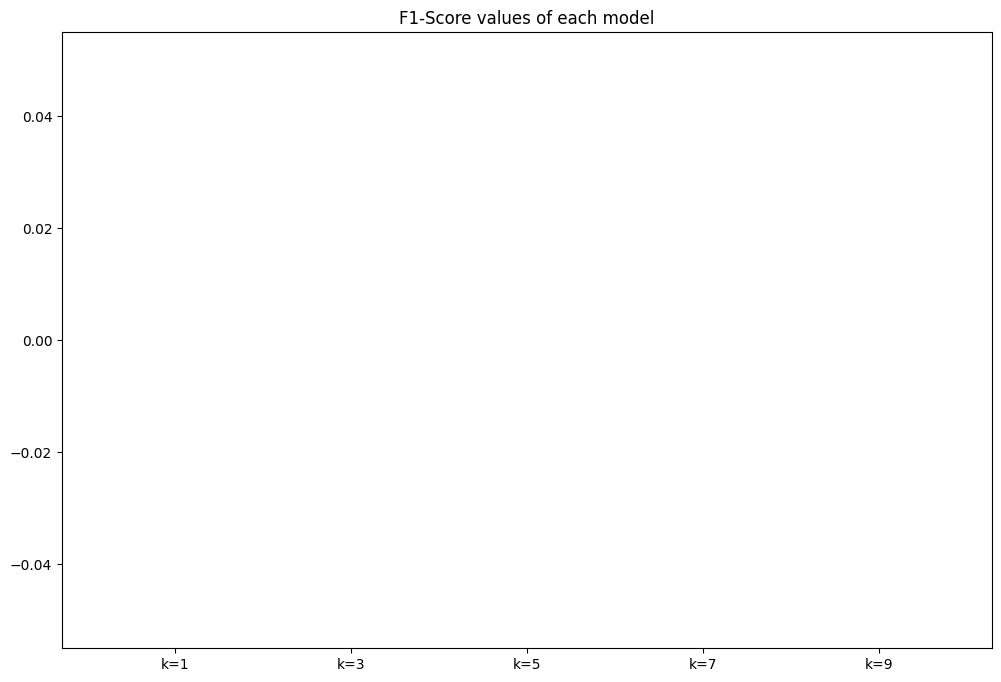

In [25]:
plt.figure(figsize=(12,8))
plt.bar(x, f1s)
plt.title('F1-Score values of each model')
plt.show()

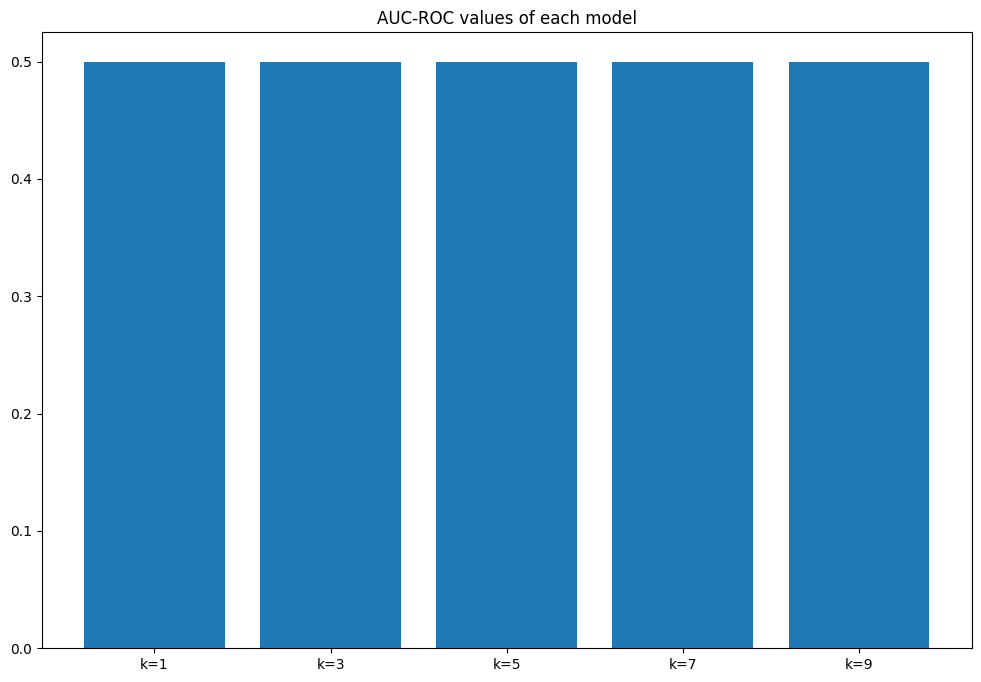

In [26]:
plt.figure(figsize=(12,8))
plt.bar(x, rocs)
plt.title('AUC-ROC values of each model')
plt.show()